In [1]:
import anndata
import pandas as pd
import numpy as np
from pandas import *
from sklearn import preprocessing
import random
from pathlib import Path
import pickle
from torchvision import transforms
import torch
from torch import nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler 
from efficientnet_pytorch import EfficientNet
from torch.utils.data import Dataset
from PIL import Image
from timeit import default_timer as timer
import matplotlib.pyplot as plt
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import accuracy_score
import scanpy as sc
import warnings
warnings.simplefilter('ignore')

In [2]:
# This script has seven input data to perform cell-type annotation. 
# To annotate customized query dataset, users only have to change input 1, input 2 and input 6. 
# The other remaining five inputs are all files related to the pre-training model.
# Those five files are already provided in the Github repository, which do not have to be replaced by users.
# First set path, users can replace it with the folder where they store the pre-trained model and sample query dataset.
path = "/Usersdata/shangru/docker/pretrained/"
# Start to calulate the time cost for using pre-trained model to annotate query dataset.
start = timer()
# Input 1: The provided query dataset.
query = anndata.read_h5ad(Path(path, "sample.h5ad"))
query.X.data

array([ 1.,  1., 17., ..., 32., 10., 17.], dtype=float32)

In [3]:
# Input 2: The provided list of genes used in the query dataset.
gene_list = pd.read_csv("pretrained_genes.csv", index_col=0).index.tolist()
remain_list = list(set(query.var.index) & set(gene_list))
query = query[:,remain_list]
sc.pp.normalize_per_cell(query)
sc.pp.log1p(query)
query

AnnData object with n_obs × n_vars = 10229 × 2994
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'donor_id', 'pool_number', 'predicted.celltype.l2', 'predicted.celltype.l2.score', 'age', 'organism_ontology_term_id', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'suspension_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'n_counts'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype'
    uns: 'log1p'

In [4]:
# Perform the same scaling method as the pre-training process.
min_max_scaler = preprocessing.MinMaxScaler()
sample = pd.DataFrame(query.X.toarray())
sample = sample.transpose()
sample = min_max_scaler.fit_transform(sample)
sample = pd.DataFrame(sample)
sample = sample.transpose()
sample.index = query.obs.index.values
sample.columns = query.var.index.values

# Check sample dataset.
sample

,ENSG00000253239,ENSG00000206129,ENSG00000109113,ENSG00000177156,ENSG00000211797,ENSG00000090104,ENSG00000213949,ENSG00000144057,ENSG00000144290,ENSG00000259001,...,ENSG00000104312,ENSG00000271857,ENSG00000104320,ENSG00000154678,ENSG00000154640,ENSG00000168913,ENSG00000184451,ENSG00000124772,ENSG00000135925,ENSG00000090382
TGCGCAGCATCAGTAC-19,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.180837,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000
AAGGTTCCAACCGCCA-28,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000
CTACCCACAGATGGGT-15,0.0,0.0,0.000000,0.049565,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.049565,0.049565,0.000000,0.0,0.0,0.12732,0.049565,0.049565,0.000000,0.697656
ATAAGAGCACTAGTAC-26,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000
TTATGCTCAATGCCAT-2,0.0,0.0,0.000000,0.000000,0.0,0.256740,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCTTTCCAGTGAAGAG-10,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.131346,0.000000
AGTCTTTCAGCTGTTA-28,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000
TTCTTAGTCTGCCCTA-17,0.0,0.0,0.000000,0.000000,0.0,0.202377,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000
GGACATTAGACGCTTT-16,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000


In [5]:
# Fill zero when genes of the pre-trained model are not included in the sample dataset.
genes = sample.columns.values.tolist()
excluded_genes = list(set(gene_list) - set(genes)) 
blank_dataframe = pd.DataFrame(np.zeros((len(sample.index.tolist()), len(excluded_genes))))
blank_dataframe.index = sample.index.tolist()
blank_dataframe.columns = excluded_genes
sample = pd.concat([sample, blank_dataframe], axis=1)
sample = sample[gene_list]
# Check sample data after filling missing genes that are not contained in the query dataset.
sample

,ENSG00000188290,ENSG00000187608,ENSG00000186891,ENSG00000186827,ENSG00000162576,ENSG00000196581,ENSG00000049249,ENSG00000142583,ENSG00000162444,ENSG00000142657,...,ENSG00000165349,ENSG00000254968,ENSG00000100968,ENSG00000121440,ENSG00000113361,ENSG00000225752,ENSG00000186652,ENSG00000232591,ENSG00000261082,ENSG00000282602
TGCGCAGCATCAGTAC-19,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAGGTTCCAACCGCCA-28,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CTACCCACAGATGGGT-15,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ATAAGAGCACTAGTAC-26,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTATGCTCAATGCCAT-2,0.0,0.117302,0.117302,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCTTTCCAGTGAAGAG-10,0.0,0.131346,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AGTCTTTCAGCTGTTA-28,0.0,0.262405,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTCTTAGTCTGCCCTA-17,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GGACATTAGACGCTTT-16,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# Use the trained image transormer to tansform the sample dataset.
# Input 4: Provided trained image transformer.
file = open(Path(path, "img_transformer_pre.obj"),'rb')
it = pickle.load(file)
file.close()
query_img = (it.transform(sample)*255).astype(np.uint8)
#Store the generated images of the sample query dataset.
np.save(Path(path, "sample.npy"), query_img)

In [7]:
class MyTestSet(Dataset):
    def __init__(self, img):
        self.img = np.load(img)
        self.transforms = transforms.Compose([transforms.ToTensor(), ])
    def __getitem__(self, index):
        img = self.img[index, :, :, :]
        img = np.squeeze(img)
        img = Image.fromarray(np.uint8(img))
        img = self.transforms(img)
        return img
    def __len__(self):
        return self.img.shape[0]

# Use generated images of query data as the input of pre-trained model.
test = MyTestSet(Path(path, "sample.npy"))
test_loader = torch.utils.data.DataLoader(test, batch_size=128, shuffle=False)

# The pre-trained model can identify 31 cell types, so num_classes is 31.
mod =EfficientNet.from_pretrained('efficientnet-b3', num_classes=31)
# Prioritize using GPUs to load the model. 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    mod = nn.DataParallel(mod)

mod.to(device)
mod = mod.to(device)

# Use pre-trained model to predict cell types on the sample query dataset.
# Input 5: Provided pre-trained model.
mod.load_state_dict(torch.load(Path(path, "checkpoint_model_pre.pth")))
mod.eval()

out = []
for i, data in enumerate(test_loader):
    query = data
    query = query.to(device)
    pred= mod(query)
    _, predicted = torch.max(pred.data, 1)
    out.append(predicted)

pred = torch.cat(out, dim=0)
pr = pred.cpu().numpy()

Loaded pretrained weights for efficientnet-b3


In [8]:
# Input 6: The cell-type label of the query dataset marked by experts in previous study.
real_label = pd.read_csv(Path(path, "real_sample_labels.csv"), index_col=0)
real_label.value_counts()

celltype         
NK                   4390
B naive              1178
CD8 TEM              1173
CD14 Mono            1084
CD8 Naive             621
CD16 Mono             536
B memory              396
CD4 TCM               185
CD4 Naive             162
cDC2                  136
Plasmablast           130
gdT                    74
HSPC                   41
pDC                    40
B intermediate         29
NK Proliferating       15
Treg                   11
MAIT                   10
NK_CD56bright           7
Platelet                7
CD8 TCM                 1
CD4 TEM                 1
dnT                     1
CD4 Proliferating       1
dtype: int64

In [9]:
# Input 7: The cell-type encoder used in the pre-training process.
file = open(Path(path, "label_encoder_pre.obj"),'rb')
le = pickle.load(file)
file.close()
pred_label = le.inverse_transform(pr)
pred_label = pd.DataFrame(pred_label)
pred_label.value_counts()

NK                   4243
B naive              1206
CD8 TEM              1185
CD14 Mono            1136
CD8 Naive             639
CD16 Mono             352
B memory              338
CD4 TCM               242
CD4 Naive             187
Plasmablast           135
cDC2                  104
CD4 CTL                97
gdT                    92
CD8 TCM                45
Eryth                  41
pDC                    39
B intermediate         37
HSPC                   28
cDC1                   25
NK Proliferating       14
Treg                   14
Platelet               10
MAIT                    7
NK_CD56bright           5
CD4 TEM                 3
CD8 Proliferating       2
CD4 Proliferating       2
dnT                     1
dtype: int64

In [10]:
# Calculate ARI and accuracy of the prediction result.
ls = list(set(pd.unique(pred_label[0]).tolist()) | set(pd.unique(real_label["celltype"]).tolist()))
acc = accuracy_score(pred_label,real_label)
le2 = preprocessing.LabelEncoder()
le2.fit(ls)
pred_label_2 = le2.transform(pred_label[0])
real_label_2 = le2.transform(real_label["celltype"])
ari = adjusted_rand_score(real_label_2, pred_label_2)
end = timer()
print("Accuray: %.03f, ARI = %.03f" % (acc, ari))
print("Total time cost in the annotation process: %.03f usec" % (end - start))

Accuray: 0.943, ARI = 0.940
Total time cost in the annotation process: 67.854 usec


In [11]:
# Evaluate the prediction result using other metrics

from sklearn.metrics import f1_score
f1_weighted = f1_score(real_label_2, pred_label_2, average='weighted')
print("F1-score(weighted): %.03f" % f1_weighted)

F1-score(weighted): 0.952


In [12]:
# Use softmax to calculate predicted probabilities.
import torch.nn.functional as nnf
pros = []
for i, data in enumerate(test_loader):
    query = data
    query = query.to(device)
    pred = mod(query)
    p = nnf.softmax(pred.data).cpu()
    pros.append(p)

In [13]:
prob = torch.cat(pros, dim=0)
# Predicted probabilities of the query dataset.
prob

tensor([[0.0037, 0.1465, 0.6342,  ..., 0.0039, 0.0044, 0.0047],
        [0.0047, 0.0108, 0.0053,  ..., 0.0041, 0.0033, 0.0052],
        [0.0106, 0.0089, 0.0085,  ..., 0.0071, 0.0028, 0.0046],
        ...,
        [0.0036, 0.0032, 0.0030,  ..., 0.0040, 0.0022, 0.0033],
        [0.0033, 0.0033, 0.0032,  ..., 0.0044, 0.0026, 0.0046],
        [0.0094, 0.0166, 0.0268,  ..., 0.0146, 0.0156, 0.0157]])

In [14]:
max_prob, predicted_classes = torch.max(prob, axis=1)
# Maximum of the predicted probabilities using the query dataset.
max_prob

tensor([0.6342, 0.8424, 0.7093,  ..., 0.8893, 0.8593, 0.3774])

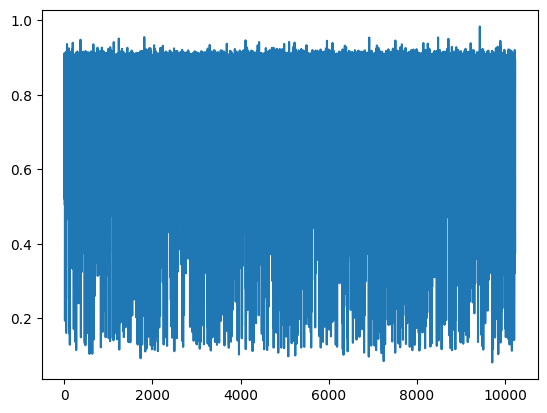

In [15]:
# Plot the maximum of the predicted probabilities.
plt.plot(max_prob)

<AxesSubplot:ylabel='Density'>

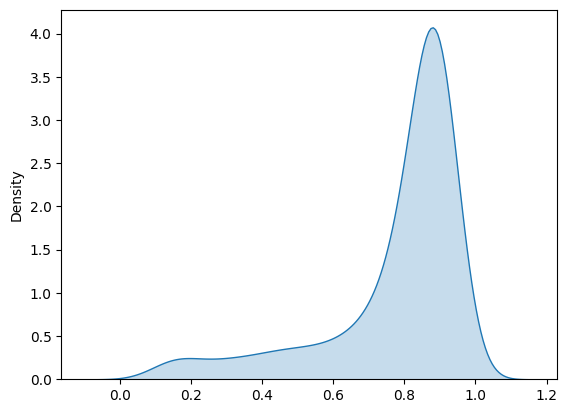

In [16]:
import seaborn as sns
# Distribution patterns of maximum predicted probabilities.
# The vast majority of predicted probabilities exceed 80%. Pre-trained model can accurately predict cell types.
sns.kdeplot(max_prob, bw_adjust=2, fill=True)